# **Introduction**

- Wearable sensors capture large volumes of time-series information, generating high-dimensional feature sets that can be used to predict human activities.

- These predictions support applications such as smart wearables, sports performance analysis, and behavior recognition systems.

- In this lab, you will build classification models to predict activity categories and evaluate how different approaches perform on high-dimensional data.

<div align="center">

![1](https://hackmd.io/_uploads/rJLw0dUngg.png)

</div>


# **Environment**
- Similar to the previous lab, We will be using .ipynb (Jupyter Notebook) files and we recommend using **Anaconda**.
- It's a chance for you the get familiar with Anaconda since our **coding exam** will be using the same.
- If you are unsure about a function or its parameters, you can use help() to view its documentation. For example: help(train_test_split)
- **For this lab, when creating a conda environment, please use the following command:                                                     
 conda install jupyter ipykernel pandas scikit-learn scipy matplotlib numpy seaborn**

# **Requirement**

- Do it individually! Not as a team! (The team is for final project)

- Deadline: **2025/10/23 23:59** (Late submission is not allowed!)

- Hand in following files to eeclass in the following format (Do not compressed!)
	- Lab3.ipynb
	- Lab3_Part1.csv
	- Lab3_Part2.csv

- Lab 3 would be covered on the coding and writing exam next time.

- Responsible TA: Yu-Chieh Wu (uc_wu@gapp.nthu.edu.tw)
	- Email for questions or visit EECS 639 during TA hours.
	- No debugging service

# **Penalty Rules**

0 points if any of the following conditions happened
- Plagiarism
- Late submission
- Not using the template or importing any other packages
- No code(“Lab3.ipynb”) submission on eeclass
- No prediction csv files submission on eeclass
- Your submission was not generated by your code

5 Points would be deducted if your submission format is incorrect

# **Lab3**
In **Lab 3**, you need to finish the following tasks:

> *   Drop Leakage Features
> *   Group-wise Data Split

1. Part I (50%): Implement a Linear Discriminant Analysis to predict the human activities.
> *   Two-class classification
> *   Visualization
> *   Whole-class classification
> *   Predict testing and generate results

2. Part II (45%): Implement a Support Vector Machine to predict the human activities.
> *   Two-class classification
> *   Visualization
> *   Whole-class classification
> *   Confusion Matrix
> *   Predict testing and generate results

3. Questions(5%):
> *  Write a report that answers the given questions.

### Import Packages

⚠️You **cannot** import any other package

In [1]:
import numpy as np
import pandas as pd
import math
import random
import csv
import matplotlib.pyplot as plt
from scipy.stats import loguniform, uniform
from sklearn.model_selection import GroupShuffleSplit, GroupShuffleSplit as GSS, GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone
import seaborn as sns
import textwrap

### Global attributes
- Define the global attributes. You can also add your own global attributes here

In [2]:
training_dataroot = 'train.csv' # Training data file file named as 'train.csv'
testing_dataroot = 'test.csv'   # Testing data file named as 'test.csv'
part1_output_path = 'Lab3_part1.csv' # Your model prediction in part I to submit to eeclass
part2_output_path = 'Lab3_part2.csv' # Your model prediction in part II to submit to eeclass

part1_output =  [] # save your model prediction in part I
part2_output = [] # save your model prediction in part II

### Load the Input File

First, load the input file **train.csv** and **test.csv**                       
You can take a look at the input features & the ground truth format:

In [3]:
df_train = pd.read_csv(training_dataroot)
df_test = pd.read_csv(testing_dataroot)

display(df_train.head(5))
display(df_test.head(5))
print("Number of training data: ", len(df_train))
print("Number of testing data: ", len(df_test))

,subject,activity,activity_id,segment,T_xacc_t001,T_xacc_t002,T_xacc_t003,T_xacc_t004,T_xacc_t005,T_xacc_t006,...,LL_zmag_t116,LL_zmag_t117,LL_zmag_t118,LL_zmag_t119,LL_zmag_t120,LL_zmag_t121,LL_zmag_t122,LL_zmag_t123,LL_zmag_t124,LL_zmag_t125
0,2,sitting,1,1,9.6704,9.6919,9.5144,9.5444,9.5824,9.5530,...,0.64412,0.64494,0.64573,0.64534,0.64509,0.64632,0.64735,0.64552,0.64738,0.64607
1,2,sitting,1,2,9.6468,9.7060,9.6914,9.6918,9.6472,9.6170,...,0.64729,0.64732,0.64620,0.64622,0.64565,0.64751,0.64751,0.64635,0.64674,0.64684
2,2,sitting,1,3,9.7652,9.7709,9.7339,9.6751,9.6309,9.7194,...,0.64690,0.64628,0.64543,0.64070,0.63983,0.63970,0.63770,0.63604,0.63582,0.63638
3,2,sitting,1,4,9.8195,9.7029,9.6291,9.6724,9.7616,9.6962,...,0.63907,0.63899,0.64065,0.63893,0.63974,0.64027,0.64033,0.63890,0.63948,0.63960
4,2,sitting,1,5,9.6925,9.6484,9.5733,9.6332,9.6484,9.5589,...,0.64061,0.64025,0.63876,0.63921,0.63960,0.63958,0.63958,0.63986,0.63906,0.63869


,subject,activity,activity_id,segment,T_xacc_t001,T_xacc_t002,T_xacc_t003,T_xacc_t004,T_xacc_t005,T_xacc_t006,...,LL_zmag_t116,LL_zmag_t117,LL_zmag_t118,LL_zmag_t119,LL_zmag_t120,LL_zmag_t121,LL_zmag_t122,LL_zmag_t123,LL_zmag_t124,LL_zmag_t125
0,1,sitting,1,1,8.1305,8.1305,8.1604,8.1603,8.1605,8.1454,...,-0.057317,-0.057444,-0.057972,-0.056593,-0.057426,-0.057689,-0.057530,-0.056789,-0.056704,-0.056262
1,1,sitting,1,2,7.9665,7.9516,7.9889,7.9367,7.9365,7.9516,...,-0.057043,-0.056163,-0.055679,-0.057854,-0.057212,-0.057939,-0.055517,-0.057188,-0.054980,-0.057155
2,1,sitting,1,3,7.8917,7.9065,7.8692,7.8917,7.8991,7.9366,...,-0.058146,-0.057066,-0.055466,-0.057584,-0.055997,-0.055858,-0.057014,-0.056803,-0.056819,-0.057301
3,1,sitting,1,4,7.9366,7.9665,7.9067,7.9218,7.9512,7.9291,...,-0.055039,-0.055790,-0.055742,-0.055786,-0.055940,-0.055377,-0.056014,-0.055160,-0.056265,-0.055743
4,1,sitting,1,5,7.8913,7.8696,7.8622,7.8920,7.9068,7.9369,...,-0.056705,-0.056045,-0.057044,-0.056459,-0.056613,-0.055738,-0.056629,-0.055203,-0.055116,-0.055548


Number of training data:  7980
Number of testing data:  1140


## Preprocess Data


### Drop Leakage Features
As we can see from the input file. Some columns are the target itself or leak information that is not available at prediction time. This is called data leakage. Leakage inflates validation scores and hurts out-of-sample generalization.

Try to use DataFrame.drop() to remove these leakage columns from your training data.

In [4]:
y = df_train['activity']
# TODO Build X by dropping leakage columns
X = df_train.drop(['activity', 'activity_id', 'subject', 'segment'], axis=1)
display(X.head(5))
display(y.head(5))

,T_xacc_t001,T_xacc_t002,T_xacc_t003,T_xacc_t004,T_xacc_t005,T_xacc_t006,T_xacc_t007,T_xacc_t008,T_xacc_t009,T_xacc_t010,...,LL_zmag_t116,LL_zmag_t117,LL_zmag_t118,LL_zmag_t119,LL_zmag_t120,LL_zmag_t121,LL_zmag_t122,LL_zmag_t123,LL_zmag_t124,LL_zmag_t125
0,9.6704,9.6919,9.5144,9.5444,9.5824,9.5530,9.5144,9.5280,9.5200,9.6117,...,0.64412,0.64494,0.64573,0.64534,0.64509,0.64632,0.64735,0.64552,0.64738,0.64607
1,9.6468,9.7060,9.6914,9.6918,9.6472,9.6170,9.7060,9.6465,9.6926,9.6475,...,0.64729,0.64732,0.64620,0.64622,0.64565,0.64751,0.64751,0.64635,0.64674,0.64684
2,9.7652,9.7709,9.7339,9.6751,9.6309,9.7194,9.7646,9.7202,9.6088,9.6901,...,0.64690,0.64628,0.64543,0.64070,0.63983,0.63970,0.63770,0.63604,0.63582,0.63638
3,9.8195,9.7029,9.6291,9.6724,9.7616,9.6962,9.7018,9.7321,9.7181,9.7189,...,0.63907,0.63899,0.64065,0.63893,0.63974,0.64027,0.64033,0.63890,0.63948,0.63960
4,9.6925,9.6484,9.5733,9.6332,9.6484,9.5589,9.6183,9.6185,9.5970,9.5597,...,0.64061,0.64025,0.63876,0.63921,0.63960,0.63958,0.63958,0.63986,0.63906,0.63869


0    sitting
1    sitting
2    sitting
3    sitting
4    sitting
Name: activity, dtype: object

### Group-wise Data Split

Some datasets are composed of multiple subjects.
If we randomly split rows, the same subject may appear in both training and validation sets. This causes subject leakage—the model learns subject-specific patterns instead of general behaviors. As a result, validation scores may look better than they really are, and the model may not generalize well to new, unseen subjects.

Let’s verify the sample count per subject in the training data.


In [5]:
subj_counts_df = df_train.groupby('subject').size().reset_index(name='n_samples')
display(subj_counts_df.sort_values('subject'))

,subject,n_samples
0,2,1140
1,3,1140
2,4,1140
3,5,1140
4,6,1140
5,7,1140
6,8,1140


Try to use GroupShuffleSplit() to keep each subject entirely in one set.

**We recommend setting random_state=0 in train_test_split to ensure that the validation data is representative and the evaluation is consistent with the testing data.**

In [6]:
groups = df_train['subject']

#TODO Split data by subject; get the index lists
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
tr_idx, val_idx = next(gss.split(X, y, groups))

#TODO Use indices to slice X and y into training and validation sets
X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx] #iloc meaning integer-location based indexing.
y_train, y_val = y.iloc[tr_idx], y.iloc[val_idx]

print("Overlap subjects (should be empty):",
      np.intersect1d(groups.iloc[tr_idx], groups.iloc[val_idx]))

print(f"Train rows: {len(X_train)} | Val rows: {len(X_val)}")

Overlap subjects (should be empty): []
Train rows: 5700 | Val rows: 2280


---
# 1. Part I (50%)
In part I, you need to implement the  Linear Discriminant Analysis to predict the activity of subject.

⚠️**Please save the prediction result for the testing data in a CSV file and submit it to eeclass. This file will be used to evaluate your assignment**⚠️

## Linear Discriminant Analysis
Linear Discriminant Analysis (LDA) is a linear classifier whose decision boundary comes from fitting class-conditional Gaussian densities and applying Bayes’ rule.

It fits one Gaussian per class and assumes a shared covariance matrix across classes.

Beyond classification, LDA also provides supervised dimensionality reduction: transform projects data onto the most discriminative directions. We will use this for visulilation.

Reference:[Linear Discriminant Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html?utm_source=chatgpt.com)

### Step 1: Two-class classification

For the LDA section, let’s start with a simplified dataset with only two classes and two features. Build a scikit-learn Pipeline that standardizes features and trains an LDA classifier.

In [7]:
selected_classes  = ('lying_on_back', 'standing')
selected_features = ['RL_xacc_t111', 'RL_xacc_t110']

# Filter Train＆Valid set to the selected classes & features
m  = y_train.isin(selected_classes)
X2 = X_train.loc[m, selected_features].copy()
y2 = y_train.loc[m].copy()
m_val  = y_val.isin(selected_classes)
X2_val = X_val.loc[m_val, selected_features].copy()
y2_val = y_val.loc[m_val].copy()

#TODO Build a pipeline that first standardizes features, then trains an LDA classifier
lda_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LDA())
])

# TODO: Fit on the training set
lda_clf.fit(X2, y2);

### Step 2: Visualization
In the visualization, we extract the LDA model’s coefficients (coef_) and intercept (intercept_), draw the linear decision boundary, and overlay the validation set. This makes the idea of linear classification clear.

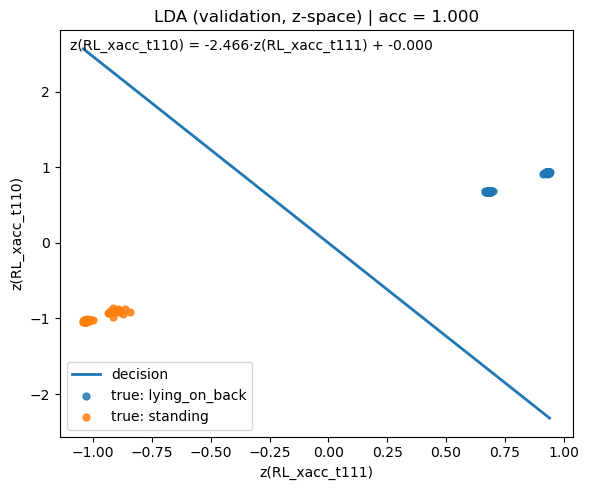

In [8]:
#Extract components from the pipeline
scaler = lda_clf.named_steps['scaler']
lda    = lda_clf.named_steps['lda']

#TODO: Extract the learned coefficients and intercept
#Hint: binary case: single discriminant; take the only vector and bias
w = lda.coef_[0]
b = lda.intercept_[0]

# Standardize the validation set
X2_val_z = scaler.transform(X2_val)

# Compute decision scores for each validation sample
scores = X2_val_z @ w + b

# Map scores to labels
pred   = np.where(scores >= 0, lda.classes_[1], lda.classes_[0])


y_true = np.asarray(y2_val)
acc = accuracy_score(y_true, pred)

plt.figure(figsize=(6,5))
z = X2_val_z; z1, z2 = z[:,0], z[:,1]

if np.isclose(w[1], 0.0):
    x0 = -b / w[0]; plt.axvline(x0, lw=2, label="decision")
    eq = f"z({selected_features[0]}) = {x0:.3f}"
else:
    xs = np.linspace(z1.min(), z1.max(), 200)
    ys = (-w[0]*xs - b) / w[1]
    plt.plot(xs, ys, lw=2, label="decision")
    eq = f"z({selected_features[1]}) = {-w[0]/w[1]:.3f}·z({selected_features[0]}) + {-b/w[1]:.3f}"


colors = {lda.classes_[0]:'#1f77b4', lda.classes_[1]:'#ff7f0e'}
for lab in lda.classes_:
    mask = (y_true == lab)
    plt.scatter(z1[mask], z2[mask], s=24, alpha=.85, label=f"true: {lab}",
                color=colors.get(lab, None))

plt.text(0.02, 0.98, eq, transform=plt.gca().transAxes, ha="left", va="top")
plt.xlabel(f"z({selected_features[0]})"); plt.ylabel(f"z({selected_features[1]})")
plt.title(f"LDA (validation, z-space) | acc = {acc:.3f}")
plt.legend(); plt.tight_layout(); plt.show()

### Step 3: Whole-class classification
Here, we will get back to the whole dataset.

Make the prediction and evaluate with accuracy and F1-weighted.

You will receive credit for this part if your model performance exceeds our pass mark.
> Acc: 0.55 | F1-weighted: 0.55

**Notice that if your score is extremely high (almost 1), the reason might be that you forgot to drop the columns associated with the label.**

In [9]:
#TODO Build a pipeline that first standardizes features, then trains an LDA classifier
lda_clf = Pipeline([

    ('scaler', StandardScaler()),
    ('lda', LDA(solver="lsqr", shrinkage="auto")
)
])


# TODO: Fit on the training set
lda_clf.fit(X_train, y_train)

# TODO: Make the prediction
y_pred_lda = lda_clf.predict(X_val)

#TODO validation accuracy & f1
acc = accuracy_score(y_val, y_pred_lda)
f1 = f1_score(y_val, y_pred_lda, average='weighted')
print(f"LDA -> Acc: {acc:.4f} | F1-weighted: {f1:.4f}")

LDA -> Acc: 0.6320 | F1-weighted: 0.6215


### Step 4: Predict testing and generate results
Lastly, we want to generate the results and write it to the CSV file.

**Remember to hand in the final output file!!**

In [10]:
# Also deal with test data leakage
X_test = df_test.drop(['activity', 'activity_id', 'subject', 'segment'], axis=1)

# Refit on all labeled data and predict test
final_lda = clone(lda_clf)
final_lda.fit(X, y)
part1_output = final_lda.predict(X_test)

# Save to CSV
with open(part1_output_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['prediction'])
    for p in part1_output:
        writer.writerow([p])

---
# 1. Part II (45%)
In part II, you need to implement the  Support Vector Machine to predict the activity of subject.

⚠️**Please save the prediction result for the testing data in a CSV file and submit it to eeclass. This file will be used to evaluate your assignment**⚠️

## Support Vector Machine

Support vector machines(SVM) are a set of supervised learning methods used for classification, regression and outliers detection.

It constructs a separating hyperplane; a good separation is achieved by the hyperplane with the largest distance (margin) to the nearest training points.

 In SVC, C trades off misclassification against decision-surface simplicity, and kernel functions (linear/RBF/poly/sigmoid) allow non-linear boundaries; for RBF, gamma controls how much influence a single sample has.

 Reference: [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html?utm_source=chatgpt.com)

### Step 1: Two-class classification
For the SVM section, let’s start with a simplified dataset with only two classes and two features too. Build a scikit-learn Pipeline that standardizes features and trains an SVM classifier.

In [11]:
selected_classes  = ('lying_on_back', 'standing')
selected_features = ['RL_xacc_t111', 'RL_xacc_t110']

# Filter Train＆Valid to the selected classes & features
m  = y_train.isin(selected_classes)
X2 = X_train.loc[m, selected_features].copy()
y2 = y_train.loc[m].copy()

m_val  = y_val.isin(selected_classes)
X2_val = X_val.loc[m_val, selected_features].copy()
y2_val = y_val.loc[m_val].copy()

# TODO: Bulid a linear SVM
svm_lin = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(random_state=0, tol=1e-5))
])

#TODO: Build a non-linear SVM
#Hine: For clearly non-linear decision boundaries in 2D visualizations, we recommend using the RBF kernel.
svm_nonlin = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=0))
])

#TODO: fit the data
svm_lin.fit(X2, y2)
svm_nonlin.fit(X2, y2);

### Step 2: Visualization

In the visualization, we extract the SVM model’s coefficients (coef_) and intercept (intercept_) and work in the standardized (z-space) used by the pipeline. We then plot:
- Decision boundary: the solid line.
- Margins: the dashed lines. These form the largest possible gap between the two classes.

To make the picture informative, we color the validation points by their true labels, and we circle the support vectors from the training set.

**Note: In this section, focus on the intuition from the plots—see how the real data behaves under different kernels. You only need to know how to extract the linear SVM parameters. Don’t worry about the plotting code.**

This block is for SVM with linear kernel

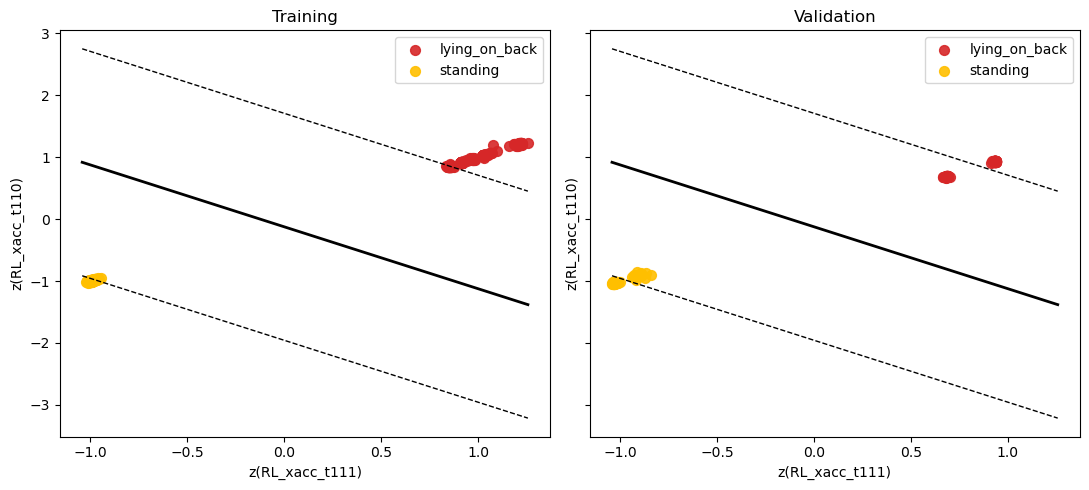

In [12]:
scaler = svm_lin.named_steps['scaler']
svc    = svm_lin.named_steps['svm']
classes = svc.classes_

Z_tr  = scaler.transform(X2)
Z_val = scaler.transform(X2_val)

# TODO: Extract the learned coefficients and intercept
w = svc.coef_[0]
b = svc.intercept_[0]

colors = {classes[0]: '#d62728', classes[1]: '#ffbf00'}

Z_all = np.vstack([Z_tr, Z_val])
x_min, x_max = Z_all[:,0].min(), Z_all[:,0].max()
xs = np.linspace(x_min, x_max, 400)
vertical = np.isclose(w[1], 0.0)
if not vertical:
    y0  = (-(w[0]*xs + b))      / w[1]  # f=0
    y1  = (-(w[0]*xs + b + 1))  / w[1]  # f=+1
    y_1 = (-(w[0]*xs + b - 1))  / w[1]  # f=-1

fig, axes = plt.subplots(1, 2, figsize=(11,5), sharex=True, sharey=True)
for ax, (Z, y_plot, title, show_sv) in zip(
    axes, [(Z_tr, y2, "Training", True), (Z_val, y2_val, "Validation", False)]
):
    y_arr = np.asarray(y_plot)
    for lab in classes:
        m = (y_arr == lab)
        ax.scatter(Z[m,0], Z[m,1], s=50, alpha=.9, color=colors[lab], label=str(lab))
    if vertical:
        for off, ls, lw in [(0,'-',2),(+1,'--',1),(-1,'--',1)]:
            ax.axvline(-(b+off)/w[0], linestyle=ls, lw=lw, color='k')
    else:
        ax.plot(xs, y0,  lw=2,  color='k')
        ax.plot(xs, y1,  '--', lw=1, color='k')
        ax.plot(xs, y_1, '--', lw=1, color='k')
    # Remove the part that plots support vectors for LinearSVC
    # if show_sv:
    #     sv = svc.support_vectors_
    #     ax.scatter(sv[:,0], sv[:,1], s=300, lw=1, facecolors='none', edgecolors='k', label='support vectors')
    ax.set_title(title)
    ax.set_xlabel(f"z({selected_features[0]})"); ax.set_ylabel(f"z({selected_features[1]})")
    ax.legend(loc='best')

plt.tight_layout(); plt.show()

This block is for SVM with non-linear kernel

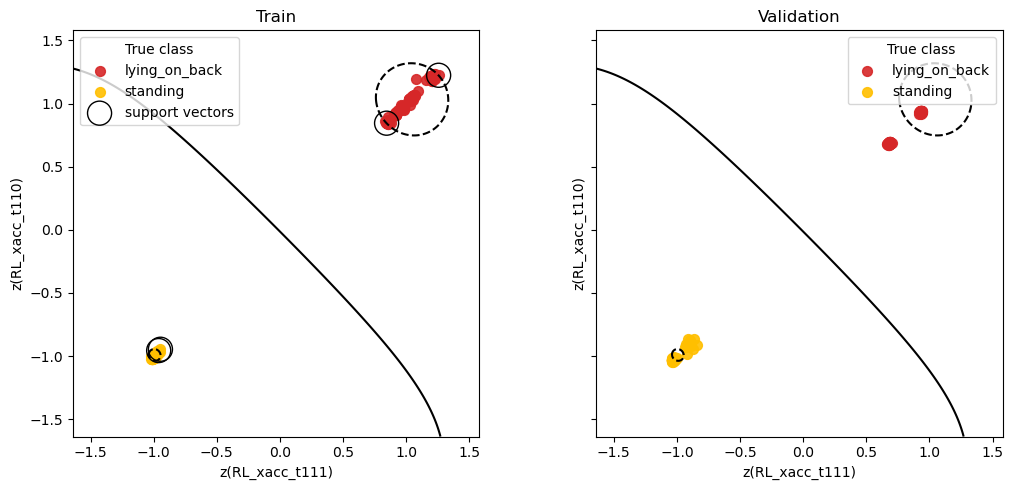

In [13]:
# --- SVM (non_linear kernel) visualization
scaler, svc = svm_nonlin.named_steps['scaler'], svm_nonlin.named_steps['svm']
classes = svc.classes_
Z_tr, Z_val = scaler.transform(X2), scaler.transform(X2_val)
colors = {classes[0]: '#d62728', classes[1]: '#ffbf00'}

# symmetric square bounds
Z = np.vstack([Z_tr, Z_val]); cx, cy = Z.mean(0)
r = 1.40 * max(np.ptp(Z[:,0])/2, np.ptp(Z[:,1])/2, 1e-6)
x_min, x_max, y_min, y_max = cx - r, cx + r, cy - r, cy + r

# grid + decision values (once)
xx, yy = np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500)
YY, XX = np.meshgrid(yy, xx)
P = svc.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)

fig, axes = plt.subplots(1, 2, figsize=(11,5), sharex=True, sharey=True)
for ax, (Zp, y_plot, title, show_sv) in zip(
    axes, [(Z_tr, y2, "Train", True), (Z_val, y2_val, "Validation", False)]
):
    y_arr = np.asarray(y_plot)
    for lab in classes:
        m = (y_arr == lab)
        ax.scatter(Zp[m,0], Zp[m,1], s=50, alpha=.9, color=colors[lab], label=str(lab))
    ax.contour(XX, YY, P, levels=[-1,0,1], linestyles=['--','-','--'], colors='k')
    if show_sv:
        sv = svc.support_vectors_
        ax.scatter(sv[:,0], sv[:,1], s=300, lw=1, facecolors='none', edgecolors='k', label='support vectors')
    ax.set(xlim=(x_min,x_max), ylim=(y_min,y_max), aspect='equal', title=title,
           xlabel=f"z({selected_features[0]})", ylabel=f"z({selected_features[1]})")
    ax.legend(title="True class", loc='best')

plt.tight_layout(); plt.show()

### Step 3: Whole-class classifiction
Here, we go back to the whole dataset.

As in Lab 2, we’ll use GridSearchCV to search hyperparameter combinations and select the best via cross-validation.

Because we need prevent subject leakage (the same subject in both training and validation folds). We therefore use **GroupKFold()** and pass subject IDs via the groups= argument in fit; this keeps all samples from a subject in a single fold.

You will receive a credit for this part if your model performance exceeds our pass mark.
> Acc: 0.78 | F1-weighted: 0.72

In [14]:
# TODO Build an SVM pipeline, fit on training, predict on validation
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(gamma='auto', random_state=0)) # Using SVC with RBF kernel as it is generally more powerful
])

# group splits for CV
groups_tr  = groups.iloc[tr_idx]
cv = GroupKFold(n_splits=5) # Using 5 folds as is common practice

# param grid
param_grid = [
    {"svm__C": [0.1, 1, 10, 100]}, # Example C values to tune
]

# grid search
gs = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid,
    scoring='f1_weighted', # Using f1_weighted as per evaluation criteria
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

# TODO: Fit the gs model
gs.fit(X_train, y_train, groups=groups_tr)

# TODO: Predict on the validation set with the best estimators
pred_svm_best = gs.predict(X_val)

# Take a look at the best parameters
print("Best params:", gs.best_params_)

#TODO Validation accuracy & f1
acc = accuracy_score(y_val, pred_svm_best)
f1 = f1_score(y_val, pred_svm_best, average='weighted')

print(f"SVM  -> Acc: {acc:.4f} | F1-weighted: {f1:.4f}")

Best params: {'svm__C': 1}
SVM  -> Acc: 0.7500 | F1-weighted: 0.7277


### Step 4: Confusion Matrix
We visualize the model’s errors with a confusion matrix—a table where rows/columns index the true and predicted classes. Dark diagonal cells indicate correct predictions; off-diagonal cells reveal which labels the classifier tends to confuse.

Reference: [Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

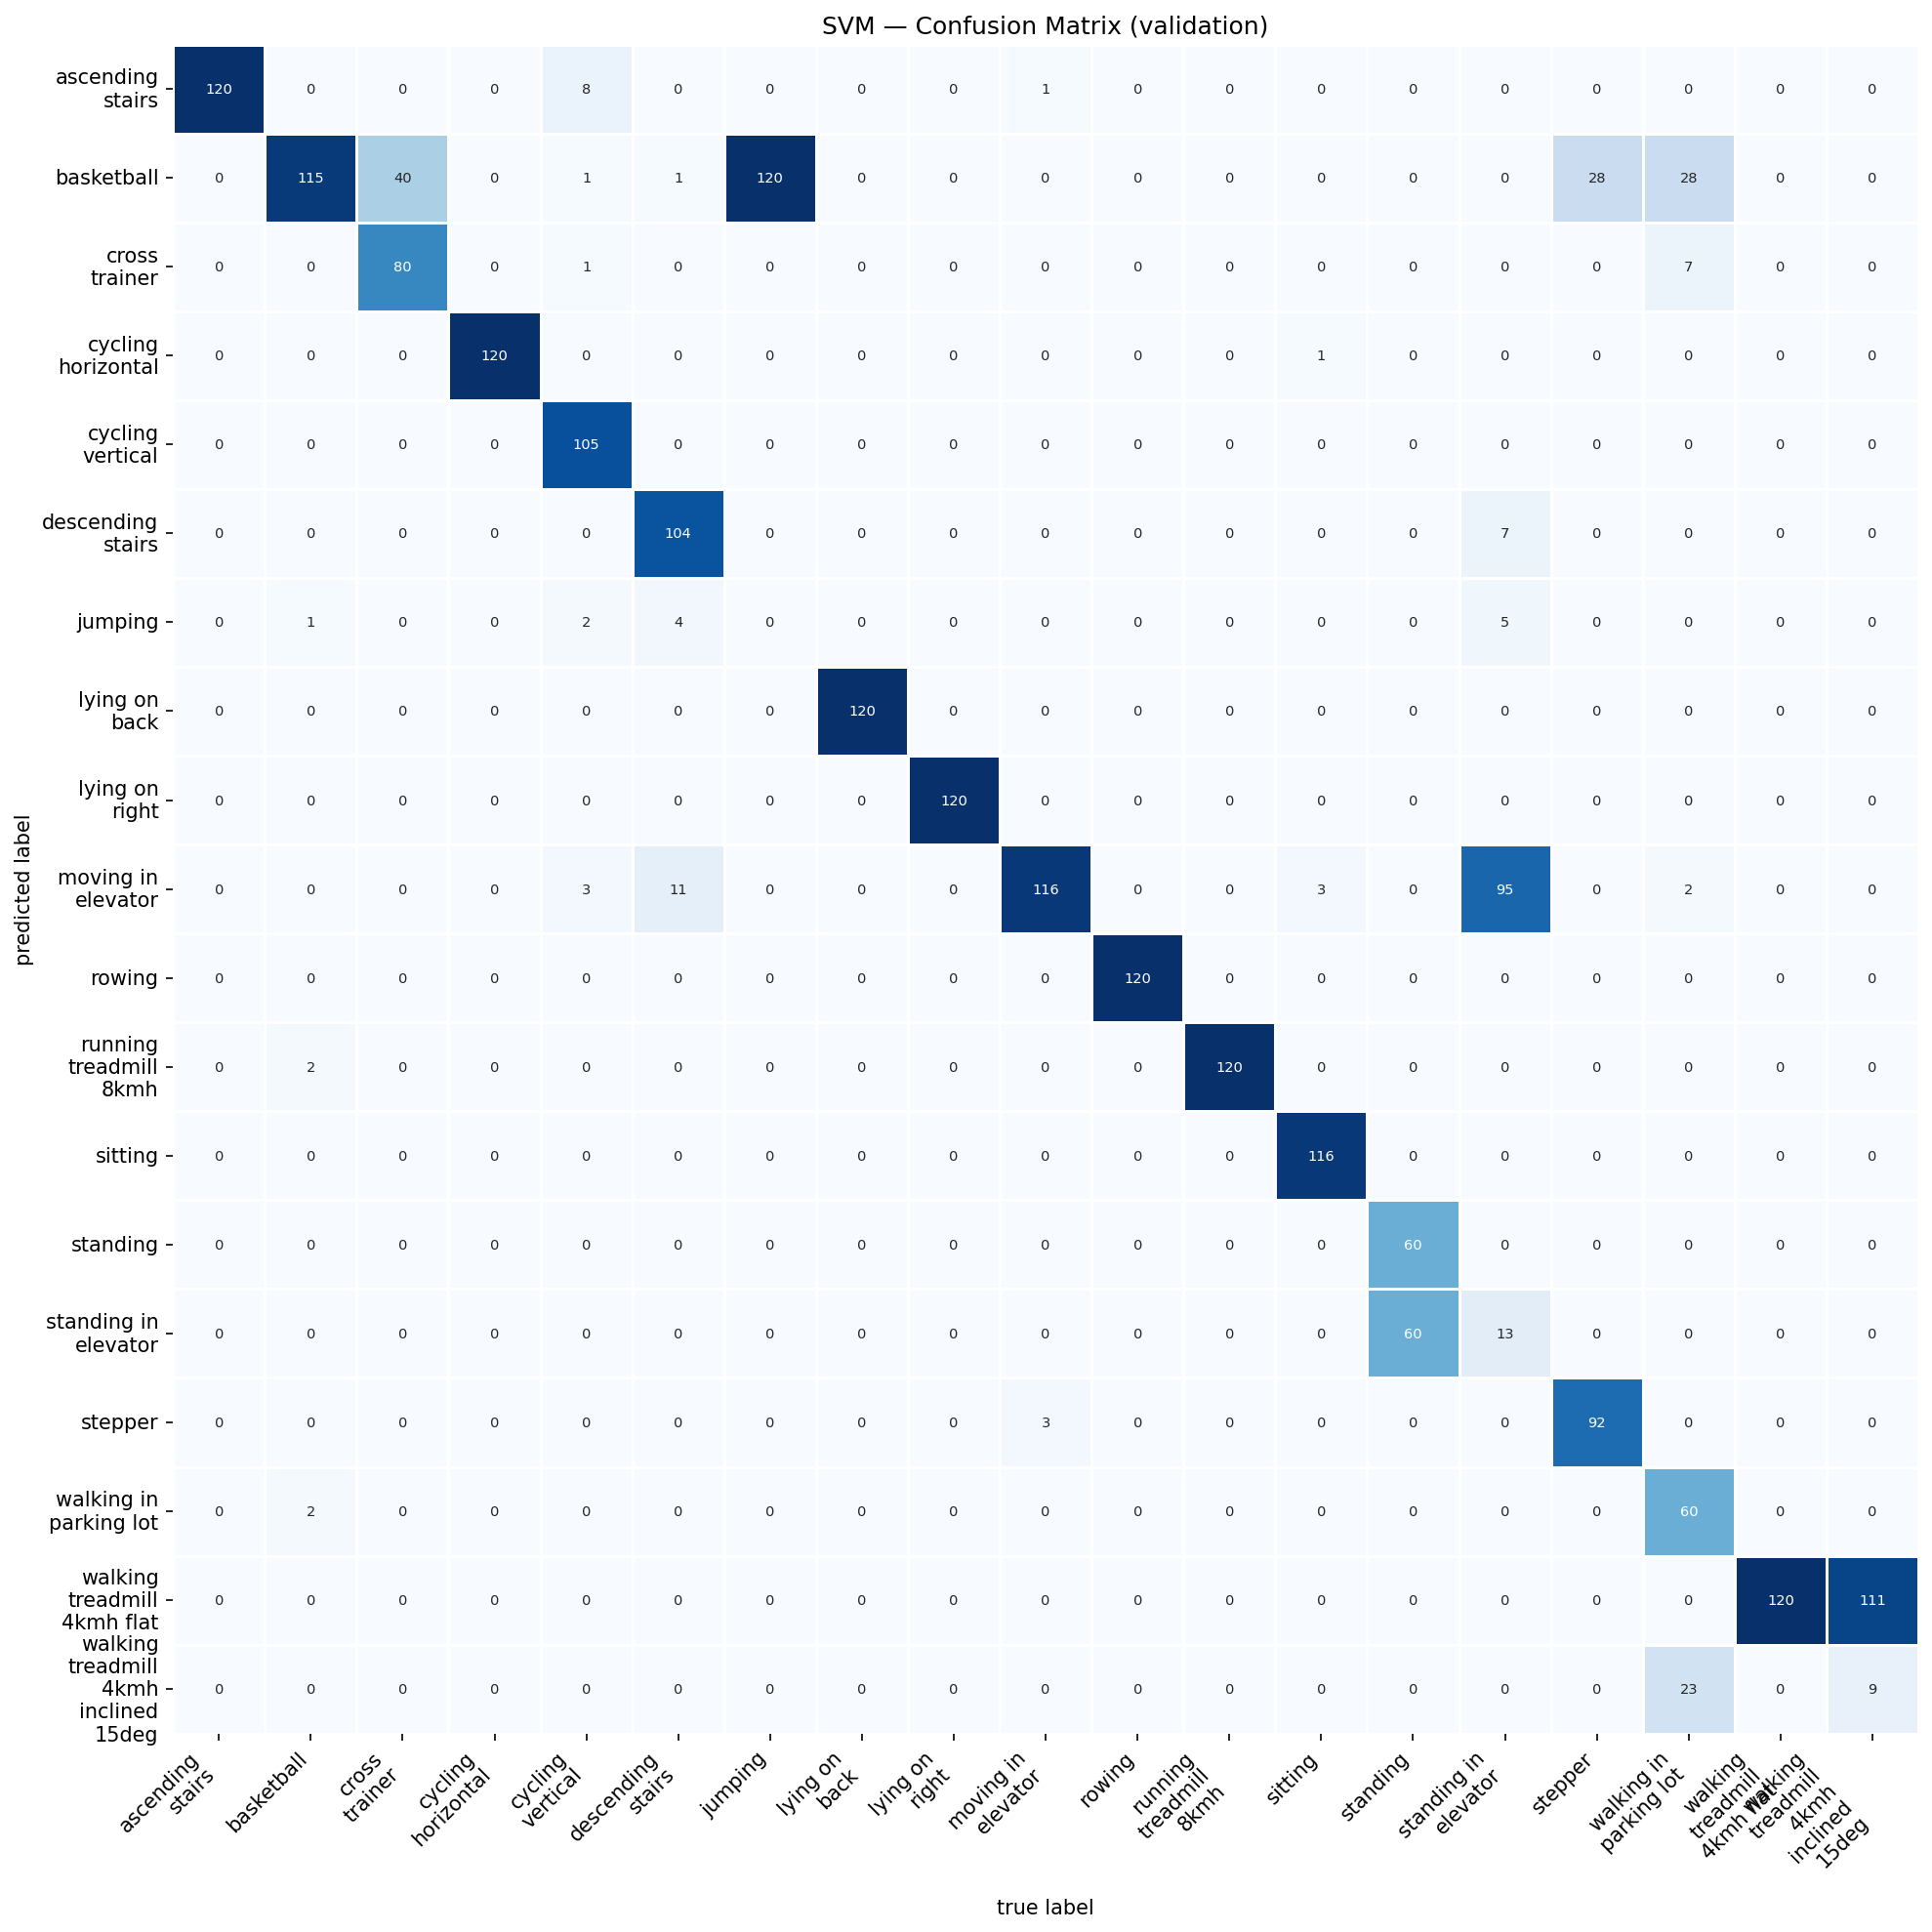

In [15]:
class_names = np.unique(np.concatenate([y_train, y_val]))

# TODO Compute confusion matrix
cm = confusion_matrix(y_val, pred_svm_best, labels=class_names)

# Visualization
labels = [textwrap.fill(str(s).replace('_', ' '), 12) for s in class_names]
n = len(labels); step = max(1, n // 15)
xt = [lbl if i % step == 0 else "" for i, lbl in enumerate(labels)]

plt.figure(figsize=(max(10, 0.7*n), max(8, 0.7*n)), dpi=150)
ax = sns.heatmap(cm.T, annot=True, fmt='d', cmap='Blues', cbar=False, square=False,
                 linewidths=0.5, linecolor='white',
                 xticklabels=xt, yticklabels=labels, annot_kws={'size': 7})
ax.set(xlabel='true label', ylabel='predicted label', title='SVM — Confusion Matrix (validation)')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout(); plt.show()

### Step 5: Predict testing and generate results

Lastly, we want to generate the results and write it to the CSV file.

> **Note: You need to decide which model (before or after fine-tuned) to use for this testing data prediction.**

**Remember to hand in the final output file!!**

In [16]:
# Also deal with test data leakage
X_test = df_test.drop(['activity', 'activity_id', 'subject', 'segment'], axis=1)

# Refit best model on all labeled data and predict test
final_svm = clone(gs.best_estimator_)
final_svm.fit(X, y)
part2_output = final_svm.predict(X_test)

# Save predictions to CSV
with open(part2_output_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['prediction'])
    for p in part2_output:
        writer.writerow([p])

# Questions (5%)

Answer the questions below in the given markdown cell:

1. Explain which features you dropped during preprocessing and why?(1%)

2. In Part I → Step 2-2, the decision boundary in z-space is $$
z(f_2)=s\cdot z(f_1)+b,\qquad
$$
First standardize the new input using training-set statistics:$$
z(f_1)=\frac{f_1-\mu_{f_1}}{\sigma_{f_1}},\quad
z(f_2)=\frac{f_2-\mu_{f_2}}{\sigma_{f_2}}
$$
where $$\mu_{f_1}=7.80,\ \sigma_{f_1}=1.10,\ \mu_{f_2}=0.52,\ \sigma_{f_2}=0.18.$$
For the new input$$ [f_1,f_2]=[9,\ 0.6]$$ compute z(f_1) and z(f_2), then decide the position relative to the decision boundary(above/below).(1%)

3.   Why can tuning the SVM parameter C improve performance? Give two possible reasons.(2%)

4.   Explain why training an SVM with a linear kernel is typically faster than with non-linear kernels (please mention time complexity).(1%)

# Your answer to the questions
1.Imagine you're taking a quiz, and someone gives you the answer key before you even start! That's basically data leakage.

We drop these features because they give the model a cheat code to the answer. The goal of the model (like LDA) is to learn how to predict an activity (like 'walking') from the complex sensor data (like accelerometer readings). If you include a leakage feature, the model won't bother learning the hard stuff; it'll just use the easy, leaked information.

This makes your model look super smart on the practice data (your training data) but totally fail in the real world (when you try to predict a new activity). Dropping the leakage features ensures the model learns the real, useful patterns.

2.No, you don't strictly need to!LDA's core math is designed to find the best separation line and already accounts for the scale differences between features using the within-class scatter matrix Sw. Because of this, scaling the data (like with Z-score normalization) won't actually change the final decision boundary.

3.The parameter C is the "strictness" control knob for the SVM. Tuning it improves performance by balancing the margin width against training errors:Controls Overfitting: A small C allows some errors, leading to a smoother, more generalized boundary that prevents overfitting to noisy training data.Manages Noise: It determines the penalty for misclassified points. By adjusting C, you allow the model to better handle messy or overlapping data without getting distracted by every single outlier.

4.Linear SVM is much faster.Linear Kernel: Uses simple, specialized algorithms that work directly on your features. It scales relatively well with data size, often having a complexity around O(NxD) (where N is samples and D is features).Non-linear Kernel: Requires the calculation of a massive Kernel Matrix by comparing every data point to every other data point. This results in a much slower complexity of O(N^2) or O(N^3), which is computationally expensive for large datasets.

# Save the Code File
Please save your code as a Jupyter Notebook file (Lab3.ipynb) and submit it to eeclass along with your prediction files (Lab3_Part1.csv and Lab3_Part2.csv).